# Analyze City of Cleveland Traffic Safety Data 

### Resources

* https://www.dot.state.oh.us/Divisions/Planning/LocalPrograms/LTAP/Documents/OH-1_FINAL.PDF
* 
*

In [31]:
import pandas as pd
import datetime as dt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet


%matplotlib inline
# set plot theme and palette
sns.set_theme()
sns.set_palette('colorblind')

## Traffic data exploration

### 1. Inspect the traffic safety dataset



In [32]:
# load dataset
traffic = pd.read_csv('traffic.csv',low_memory=False)

traffic.head()

,OBJECTID,DOCUMENT_NBR,CRASH_YR,CRASH_MONTH_YEAR,DISTRICT_NBR,NLFID,NLF_JUR_CD,NLF_COUNTY_CD,COUNTY_LOG_NBR,ODOT_LATITUDE_NBR,...,U3_SEQ_OF_EVENTS_4_CD,U3_SEQ_OF_EVENTS_5_CD,U3_SEQ_OF_EVENTS_6_CD,U3_SPECIAL_FUNCTION_CD,U3_TRAFFIC_CONTROL_CD,U3_TYPE_OF_UNIT_CD,UNRESTRAIN_OCCUPANTS,WEATHER_COND_CD,x,y
0,1,20174001939,2017,1/1/2017 12:00:00 AM,12,CCUYCR00398**C,C,CUY,0.844,41.451878,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,2.209356e+06,651613.028182
1,2,20174001941,2017,1/1/2017 12:00:00 AM,12,CCUYCR00721**C,C,CUY,0.579,41.499732,...,NaN,NaN,NaN,NaN,NaN,NaN,0,4,2.192889e+06,668889.970662
2,3,20174001952,2017,1/1/2017 12:00:00 AM,12,CCUYCR00009**C,C,CUY,4.978,41.536373,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,2.209200e+06,682400.346857
3,4,20174001969,2017,1/1/2017 12:00:00 AM,12,SCUYUS00322**C,S,CUY,0.860,41.503394,...,NaN,NaN,NaN,NaN,NaN,NaN,0,4,2.193393e+06,670229.092984
4,5,20174001970,2017,1/1/2017 12:00:00 AM,12,CCUYCR00009**C,C,CUY,5.765,41.540792,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,2.212957e+06,684048.772038


## Distracted Driver Rates

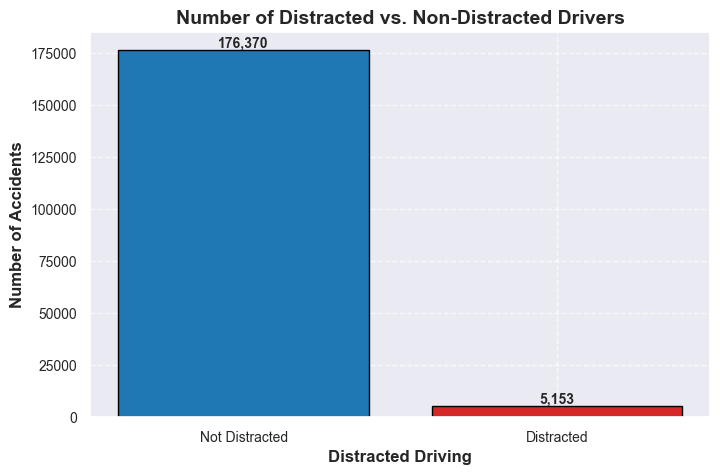

In [33]:

# 1. Count the number of distracted and non-distracted drivers
distracted_counts = traffic['DISTRACTED_DRIVER_IND'].value_counts()

# 2. Create Bar Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(
    x=['Not Distracted', 'Distracted'],
    height=distracted_counts.values,
    color=['#1f77b4', '#d62728'],  # Blue and Red with better contrast
    edgecolor='black'
)

# 3. Add Data Labels on Top of Bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height:,}', 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        fontweight='bold'
    )

# 4. Add Labels and Title
plt.xlabel("Distracted Driving", fontsize=12, fontweight='bold')
plt.ylabel("Number of Accidents", fontsize=12, fontweight='bold')
plt.title("Number of Distracted vs. Non-Distracted Drivers", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# 5. Add Count Annotations
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the chart
plt.show()


DISTRACTED_DRIVER Distribution:
0    176370
1      5153
Name: DISTRACTED_DRIVER, dtype: int64

CRASH_SEVERITY Distribution:
Fatal       126553
Severe       34925
Serious      16104
Moderate      3397
Minor          544
Name: CRASH_SEVERITY, dtype: int64

Severity by Distracted Driver:
CRASH_SEVERITY      Fatal  Minor  Moderate  Serious  Severe
DISTRACTED_DRIVER                                          
0                  123572    540      3257    15414   33587
1                    2981      4       140      690    1338


<Figure size 1000x600 with 0 Axes>

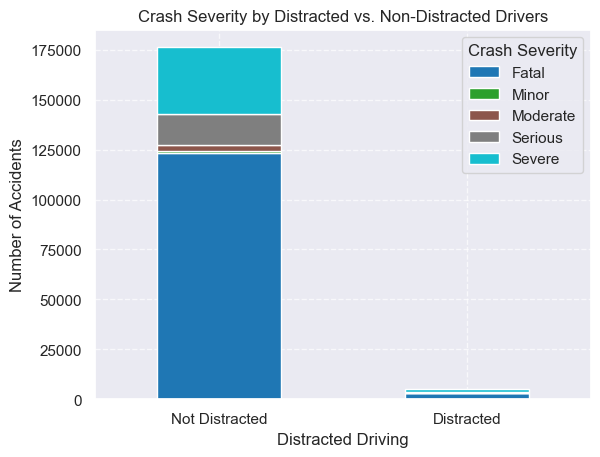

In [34]:
# 1. Define Mappings for Severity and Distracted Indicators
severity_mapping = {
    1: "Minor",
    2: "Moderate",
    3: "Serious",
    4: "Severe",
    5: "Fatal"
}
distracted_mapping = {
    'N': 0,
    'Y': 1
}

traffic['DISTRACTED_DRIVER'] = traffic['DISTRACTED_DRIVER_IND'].map(distracted_mapping).fillna(0).astype(int)
traffic['CRASH_SEVERITY'] = traffic['CRASH_SEVERITY_CD'].map(severity_mapping).fillna('Unknown')

print("DISTRACTED_DRIVER Distribution:")
print(traffic['DISTRACTED_DRIVER'].value_counts())
print("\nCRASH_SEVERITY Distribution:")
print(traffic['CRASH_SEVERITY'].value_counts())

severity_by_distracted = traffic.groupby(['DISTRACTED_DRIVER', 'CRASH_SEVERITY']).size().unstack(fill_value=0)
for col in ['Minor', 'Moderate', 'Serious', 'Severe', 'Fatal']:
    if col not in severity_by_distracted.columns:
        severity_by_distracted[col] = 0

print("\nSeverity by Distracted Driver:")
print(severity_by_distracted)

plt.figure(figsize=(10, 6))
severity_by_distracted.plot(kind="bar", stacked=True, colormap='tab10')
plt.title("Crash Severity by Distracted vs. Non-Distracted Drivers")
plt.xlabel("Distracted Driving")
plt.ylabel("Number of Accidents")
plt.legend(title="Crash Severity")
plt.xticks(ticks=[0, 1], labels=["Not Distracted", "Distracted"], rotation=0)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


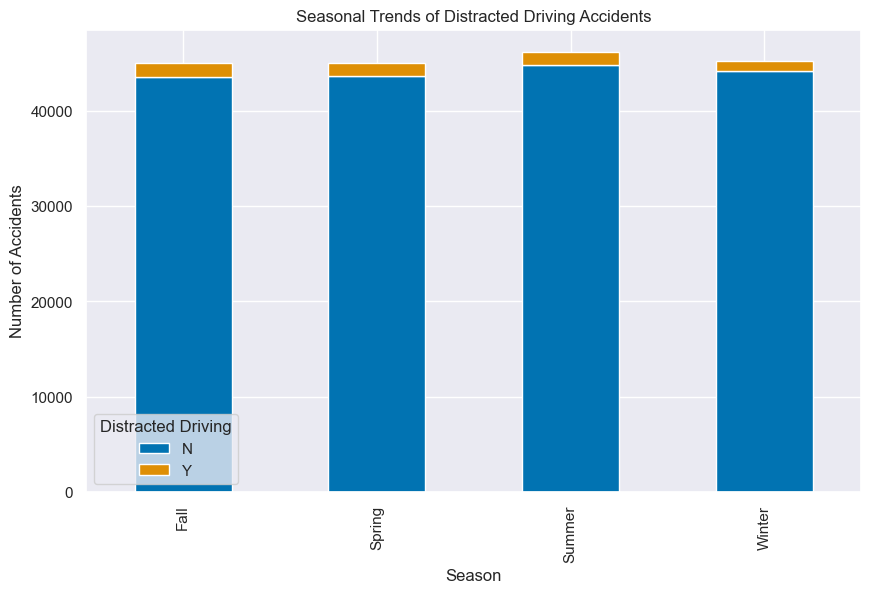

In [35]:
traffic['CRASH_MONTH_YEAR'] = pd.to_datetime(traffic['CRASH_MONTH_YEAR'])
traffic['SEASON'] = traffic['CRASH_MONTH_YEAR'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

season_distracted = traffic.groupby(['SEASON', 'DISTRACTED_DRIVER_IND']).size().unstack()

# Plot
season_distracted.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Seasonal Trends of Distracted Driving Accidents")
plt.xlabel("Season")
plt.ylabel("Number of Accidents")
plt.legend(title="Distracted Driving")
plt.show()


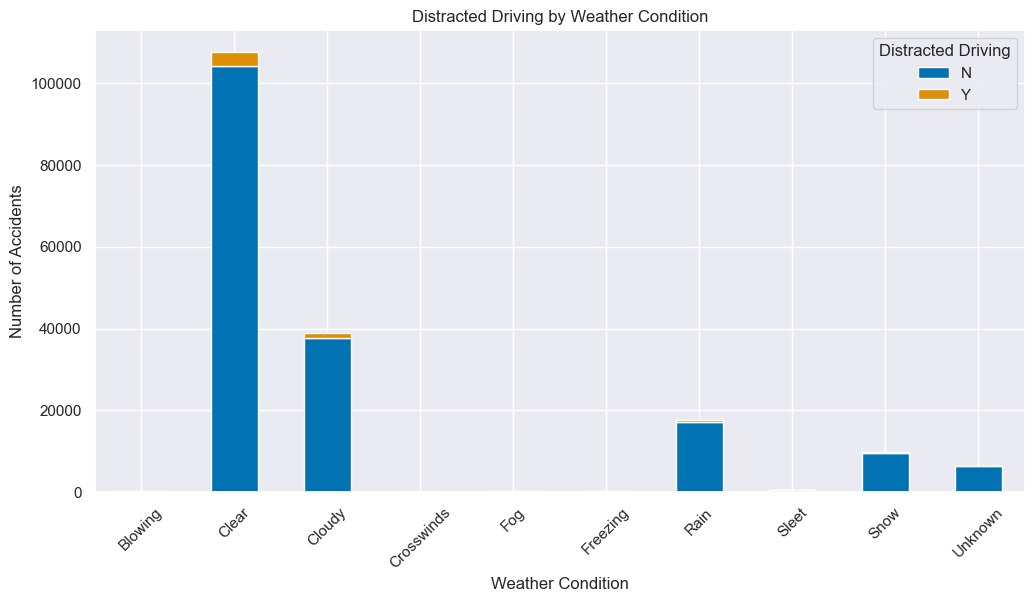

In [36]:
weather_mapping = {

1: "Clear",
2: "Cloudy",
3: "Fog",
4: "Rain",
5: "Sleet",
6: "Snow",
7: "Crosswinds",
8: "Blowing",
9: "Freezing",
99: "Unknown"


}

traffic['WEATHER_COND_CD'] = pd.to_numeric(traffic['WEATHER_COND_CD'], errors='coerce')

# Apply mappings
traffic['WEATHER_CONDITION'] = traffic['WEATHER_COND_CD'].map(weather_mapping)

traffic = traffic.dropna(subset=['CRASH_SEVERITY'])

distracted_weather = traffic.groupby(['WEATHER_CONDITION', 'DISTRACTED_DRIVER_IND']).size().unstack()

# Plot
distracted_weather.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Distracted Driving by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.legend(title="Distracted Driving")
plt.xticks(rotation=45)
plt.show()


20:52:18 - cmdstanpy - INFO - Chain [1] start processing
20:52:18 - cmdstanpy - INFO - Chain [1] done processing


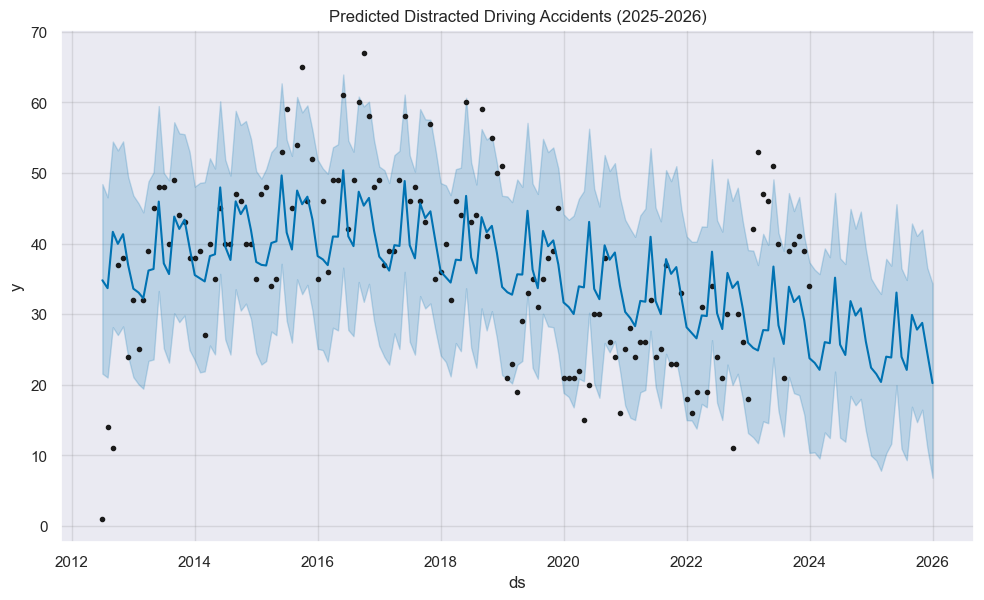

In [37]:
import pandas as pd
from prophet import Prophet

# Convert to datetime
traffic['CRASH_MONTH_YEAR'] = pd.to_datetime(traffic['CRASH_MONTH_YEAR'], errors='coerce')

# Map distracted driver indicator
traffic['DISTRACTED_DRIVER_IND'] = traffic['DISTRACTED_DRIVER_IND'].map({'Y': 1, 'N': 0})

# Filter only distracted driving cases
distracted_traffic = traffic[traffic['DISTRACTED_DRIVER_IND'] == 1]

# Set datetime as the index
distracted_traffic = distracted_traffic.set_index('CRASH_MONTH_YEAR')

# Resample by month and count occurrences
distracted_trend = distracted_traffic.resample('M').size().reset_index()

# Rename columns for Prophet
distracted_trend.columns = ['ds', 'y']

# Drop missing dates in 'ds'
distracted_trend = distracted_trend.dropna(subset=['ds'])

# Check if the dataset is empty
if distracted_trend.empty:
    raise ValueError("No valid data available for forecasting.")

# Create full date range to ensure no missing months
full_dates = pd.date_range(start=distracted_trend['ds'].min(), end=distracted_trend['ds'].max(), freq='M')
distracted_trend = pd.DataFrame({'ds': full_dates}).merge(distracted_trend, on='ds', how='left').fillna(0)

# Fit the model
model = Prophet()
model.fit(distracted_trend)

# Create a dataframe for future predictions (24 months ahead)
future = model.make_future_dataframe(periods=24, freq='M')

# Generate predictions
forecast = model.predict(future)

# Plot results
model.plot(forecast)
plt.title("Predicted Distracted Driving Accidents (2025-2026)")
plt.show()



### Crash Rates by Weather Conditions

CRASH_SEVERITY     Fatal  Minor  Moderate  Serious  Severe
WEATHER_CONDITION                                         
Blowing Sand/Dust    163      0         7        8      48
Clear              74307    297      2104     9868   20973
Cloudy             27343    184       787     3267    7330
Fog/Smoke            361      1         9       55      97
Other                184      0         2       22      38
Rain                 193      1         8       25      56
Severe Crosswinds     64      0         0        5      16
Sleet/Hail          7176     10       100      744    1725
Snow               11683     50       314     1787    3727
Unknown             5079      1        66      323     915


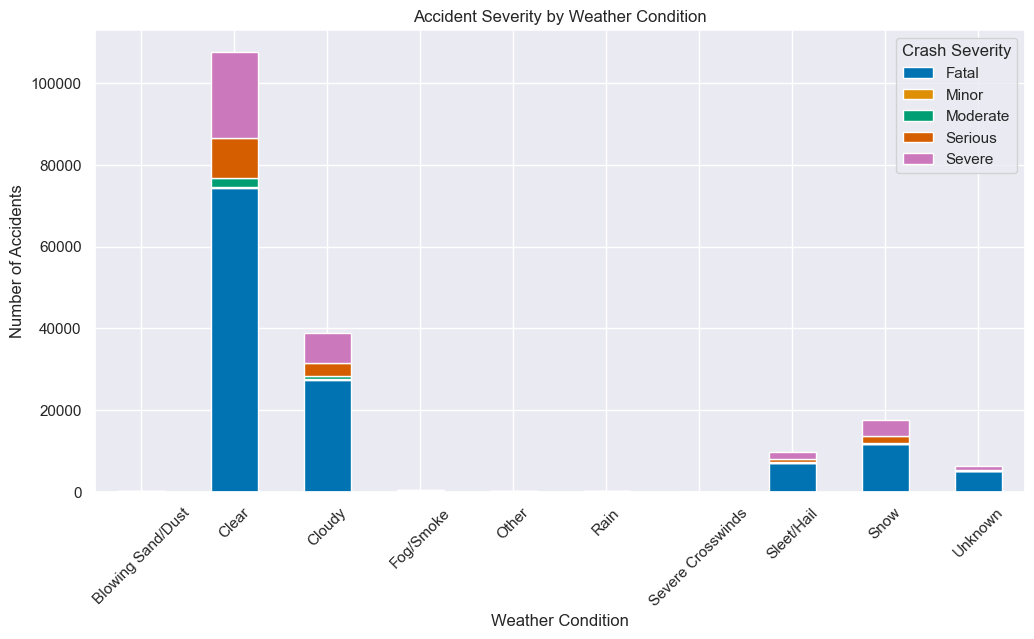

In [38]:
# Define severity and weather mappings
severity_mapping = {
    1: "Minor",
    2: "Moderate",
    3: "Serious",
    4: "Severe",
    5: "Fatal"
}

weather_mapping = {
    1: "Clear",
    2: "Cloudy",
    3: "Rain",
    4: "Snow",
    5: "Fog/Smoke",
    6: "Sleet/Hail",
    7: "Severe Crosswinds",
    8: "Blowing Sand/Dust",
    9: "Other",
    99: "Unknown"
}

# Convert to numeric if necessary
traffic['WEATHER_COND_CD'] = pd.to_numeric(traffic['WEATHER_COND_CD'], errors='coerce')
traffic['CRASH_SEVERITY_CD'] = pd.to_numeric(traffic['CRASH_SEVERITY_CD'], errors='coerce')

# Apply mappings
traffic['WEATHER_CONDITION'] = traffic['WEATHER_COND_CD'].map(weather_mapping)
traffic['CRASH_SEVERITY'] = traffic['CRASH_SEVERITY_CD'].map(severity_mapping)

# Drop missing values after mapping
traffic = traffic.dropna(subset=['WEATHER_CONDITION', 'CRASH_SEVERITY'])

# Group by Weather Condition and Severity
severity_by_weather = traffic.groupby(['WEATHER_CONDITION', 'CRASH_SEVERITY']).size().unstack(fill_value=0)

# Debugging: Check if data exists
print(severity_by_weather)

# Plot the results
severity_by_weather.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Accident Severity by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.legend(title="Crash Severity")
plt.xticks(rotation=45)
plt.show()


In [39]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime format
traffic['CRASH_MONTH_YEAR'] = pd.to_datetime(traffic['CRASH_MONTH_YEAR'], errors='coerce')

# Map months to their corresponding season
traffic['SEASON'] = traffic['CRASH_MONTH_YEAR'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Filter only past data (before 2025)
past_accidents = traffic[traffic['CRASH_MONTH_YEAR'] < '2025-01-01']

# Aggregate accident count per month for summer seasons only
summer_accidents = past_accidents[past_accidents['SEASON'] == 'Summer'].groupby('CRASH_MONTH_YEAR').size().reset_index()

